In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.models import Sequential
from collections import defaultdict
from tensorflow.keras.layers import LeakyReLU


C:\Users\User\miniconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


- this model does not need to be perfect as both models perform somewhat well on the opposite datasets and likely can work with the instances where the format is not dramatically different

In [11]:
batch_size = 64
image_height = 128
image_width = 128

In [12]:
train = tf.keras.utils.image_dataset_from_directory(
    './Seperation_train',
    labels='inferred',
    validation_split=0.3,
    subset='training',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)

valid = tf.keras.utils.image_dataset_from_directory(
    './Seperation_train',
    labels='inferred',
    validation_split=0.3,
    subset='validation',
    seed=42, # not important but needed for reproducing the code
    image_size=(image_height, image_width),
    batch_size=batch_size)


Found 7977 files belonging to 2 classes.
Using 5584 files for training.
Found 7977 files belonging to 2 classes.
Using 2393 files for validation.


- because the differences in the data are slight I don't believe it will be worth while to do any data augmentation as it may confuse the model

In [13]:
class_names = train.class_names
class_names

['model_A_lrod', 'model_B_wd']

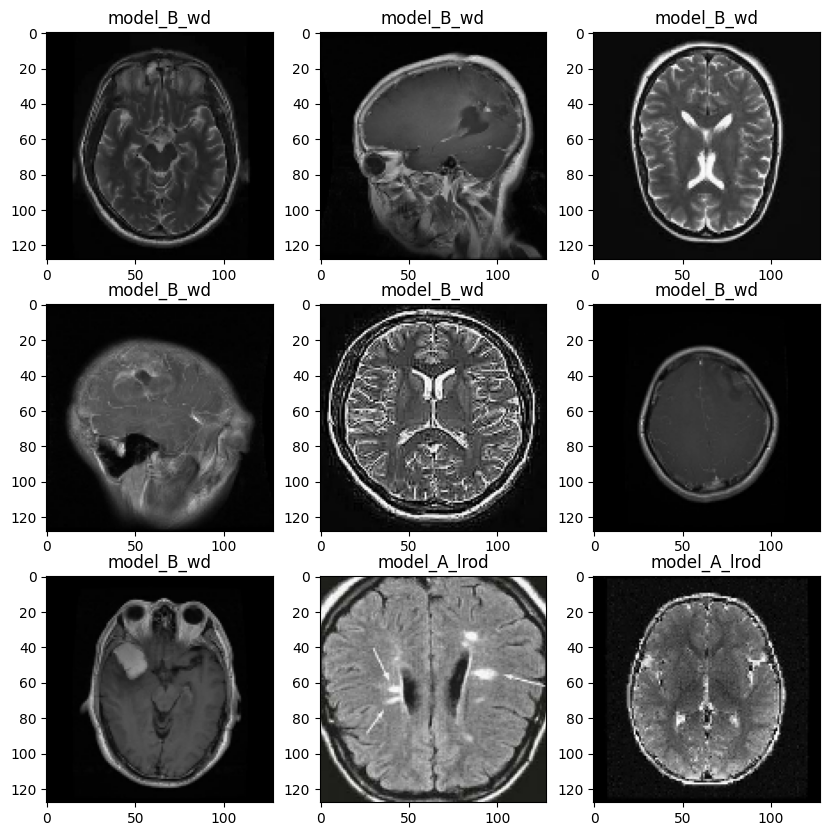

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("on")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(800).prefetch(buffer_size=AUTOTUNE)
valid = valid.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


- copying most accurate model architecture from the previous tests but excluding augmentation

In [21]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(320, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # raised dropout rate slightly
    layers.Flatten(),
    layers.Dense(128, activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dense(num_classes, name="outputs")
])


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
%%time
# best model had 38 so increasing to 40 as only 2 categories as opposed to 4 should make prediction more difficult to learn
epochs=50
history = model.fit(
  train,
  validation_data=valid,
  epochs=epochs
)

Epoch 1/50
88/88 [==============================] - 45s 499ms/step - loss: 0.4302 - accuracy: 0.7754 - val_loss: 0.3241 - val_accuracy: 0.8186
Epoch 2/50
88/88 [==============================] - 41s 466ms/step - loss: 0.3298 - accuracy: 0.8148 - val_loss: 0.3244 - val_accuracy: 0.8061
Epoch 3/50
88/88 [==============================] - 40s 451ms/step - loss: 0.3235 - accuracy: 0.8150 - val_loss: 0.3171 - val_accuracy: 0.8090
Epoch 4/50
88/88 [==============================] - 39s 448ms/step - loss: 0.3068 - accuracy: 0.8193 - val_loss: 0.3050 - val_accuracy: 0.8207
Epoch 5/50
88/88 [==============================] - 40s 454ms/step - loss: 0.2948 - accuracy: 0.8225 - val_loss: 0.3154 - val_accuracy: 0.8186
Epoch 6/50
88/88 [==============================] - 39s 439ms/step - loss: 0.2936 - accuracy: 0.8331 - val_loss: 0.2984 - val_accuracy: 0.8149
Epoch 7/50
88/88 [==============================] - 39s 441ms/step - loss: 0.2782 - accuracy: 0.8354 - val_loss: 0.3125 - val_accuracy: 0.8048

KeyboardInterrupt: 

- stopped it early as the network was overfitting 
- could introduce more dropout and augment the data slightly with random flips

In [26]:
data_augmentation = tf.keras.Sequential([   
    # flips it upside down
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    # flips it other way
    tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"),
])

In [27]:
num_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dropout(0.3), # some earlier dropout
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dropout(0.3), # some earlier dropout
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(320, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # raised dropout rate slightly
    layers.Flatten(),
    layers.Dense(128, activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dense(num_classes, name="outputs")
])


In [28]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
%%time
#lowering as last time was too much 
epochs=40
history = model2.fit(
  train,
  validation_data=valid,
  epochs=epochs
)

Epoch 1/40
88/88 [==============================] - 48s 525ms/step - loss: 0.4758 - accuracy: 0.7676 - val_loss: 0.3613 - val_accuracy: 0.8036
Epoch 2/40
88/88 [==============================] - 48s 543ms/step - loss: 0.3430 - accuracy: 0.8114 - val_loss: 0.3470 - val_accuracy: 0.8069
Epoch 3/40
88/88 [==============================] - 46s 524ms/step - loss: 0.3253 - accuracy: 0.8155 - val_loss: 0.3256 - val_accuracy: 0.8061
Epoch 4/40
88/88 [==============================] - 45s 516ms/step - loss: 0.3146 - accuracy: 0.8213 - val_loss: 0.3117 - val_accuracy: 0.8203
Epoch 5/40
88/88 [==============================] - 45s 516ms/step - loss: 0.3026 - accuracy: 0.8268 - val_loss: 0.3090 - val_accuracy: 0.8174
Epoch 6/40
88/88 [==============================] - 45s 515ms/step - loss: 0.2950 - accuracy: 0.8266 - val_loss: 0.3108 - val_accuracy: 0.8170
Epoch 7/40
88/88 [==============================] - 46s 521ms/step - loss: 0.2950 - accuracy: 0.8292 - val_loss: 0.3086 - val_accuracy: 0.8157

KeyboardInterrupt: 

- same issue

In [33]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./Seperation_test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './Seperation_test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predictions = model.predict(img_array, verbose=None)
        predicted_class = class_names[np.argmax(predictions)]

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)
        
        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))


Accuracy: 75.31%
model_A_lrod: 402 / 981
rate of failure: 	 40.97859327217125
model_B_wd: 164 / 1311
rate of failure: 	 12.509534706331046
CPU times: total: 1min 39s
Wall time: 3min 22s


In [34]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./Seperation_test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './Seperation_test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predictions = model2.predict(img_array, verbose=None)
        predicted_class = class_names[np.argmax(predictions)]

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)
        
        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))


Accuracy: 74.56%
model_A_lrod: 438 / 981
rate of failure: 	 44.64831804281346
model_B_wd: 145 / 1311
rate of failure: 	 11.060259344012206
CPU times: total: 1min 50s
Wall time: 3min 31s


- both are not great. probably better with just a few epochs regardless of model

In [35]:
num_classes = len(class_names)

model3 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dropout(0.3), # some earlier dropout
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dropout(0.3), # some earlier dropout
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Conv2D(320, 3, padding='same', activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # raised dropout rate slightly
    layers.Flatten(),
    layers.Dense(128, activation=LeakyReLU(alpha=0.11)),  # Leaky ReLU activation
    layers.Dense(num_classes, name="outputs")
])


In [36]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
%%time
# 5 epochs was where the model maxed out on validation accuracy
epochs=5
history = model3.fit(
  train,
  validation_data=valid,
  epochs=epochs
)

Epoch 1/5
88/88 [==============================] - 131s 1s/step - loss: 0.4632 - accuracy: 0.7738 - val_loss: 0.3336 - val_accuracy: 0.8099
Epoch 2/5
88/88 [==============================] - 124s 1s/step - loss: 0.3465 - accuracy: 0.8080 - val_loss: 0.3296 - val_accuracy: 0.8161
Epoch 3/5
88/88 [==============================] - 124s 1s/step - loss: 0.3239 - accuracy: 0.8139 - val_loss: 0.3225 - val_accuracy: 0.8191
Epoch 4/5
88/88 [==============================] - 124s 1s/step - loss: 0.3102 - accuracy: 0.8179 - val_loss: 0.3176 - val_accuracy: 0.8270
Epoch 5/5
88/88 [==============================] - 124s 1s/step - loss: 0.3022 - accuracy: 0.8272 - val_loss: 0.4955 - val_accuracy: 0.8028
CPU times: total: 4min 36s
Wall time: 10min 26s


In [38]:
%%time


# Create a dictionary to store false prediction counts for each class
false_predictions = defaultdict(int)

# Define the class names based on the folder names
class_names = sorted(os.listdir('./Seperation_test'))  # Replace with the path to your dataset folder

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Specify the path to the test dataset folder
test_data_folder = './Seperation_test'  # Replace with the path to your test dataset folder

# Iterate through the test dataset
for class_name in class_names:
    class_folder = os.path.join(test_data_folder, class_name)
    if not os.path.isdir(class_folder):
        continue

    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load and preprocess the image
        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Make predictions
        predictions = model3.predict(img_array, verbose=None)
        predicted_class = class_names[np.argmax(predictions)]

        # Append true and predicted labels to the lists
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)
        
        # Check if the prediction is correct
        if predicted_class != class_name:
            false_predictions[class_name] += 1

# Calculate accuracy
correct_predictions = [true == pred for true, pred in zip(true_labels, predicted_labels)]
accuracy = sum(correct_predictions) / len(correct_predictions)


# Print accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

def getpercent(numerator, denominator):
    return (numerator / denominator) * 100

for class_name, wrong_count in false_predictions.items():
    class_folder = os.path.join(test_data_folder, class_name)
    files = os.listdir(class_folder)
    total_class_count = len(files)
    print(f"{class_name}: {wrong_count} / {total_class_count}")
    print("rate of failure: \t", getpercent(wrong_count, total_class_count))


Accuracy: 78.14%
model_A_lrod: 59 / 981
rate of failure: 	 6.014271151885831
model_B_wd: 442 / 1311
rate of failure: 	 33.71472158657514
CPU times: total: 2min 3s
Wall time: 3min 52s


- adequate results, probably won't improve when data is not significantly different

In [39]:
model3.save('./Model3_Seperation/')

INFO:tensorflow:Assets written to: ./Model3_Seperation/assets


INFO:tensorflow:Assets written to: ./Model3_Seperation/assets
